# 🌍 Qartezator: Yet another aerial image-to-map translator

## Environment setup

First you need to install qartezator from project root directory

In [1]:
!git clone https://github.com/AndranikSargsyan/qartezator.git

Cloning into 'qartezator'...
remote: Enumerating objects: 158, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (117/117), done.
remote: Total 158 (delta 55), reused 137 (delta 38), pack-reused 0
Receiving objects: 100% (158/158), 1.12 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (55/55), done.


In [2]:
import random
from pathlib import Path
from typing import Union

import cv2
import numpy as np


def load_image(path: Union[str, Path] = None) -> np.ndarray:
    """Loads RGB image.
    Args:
        path (Union[str, Path]): Path to image.
    Returns:
        np.ndarray.
    """
    image = cv2.imread(str(path))
    return cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


def seed_worker(worker_id):
    """Seeds Dataloader worker"""
    worker_seed = np.random.get_state()[1][0] + worker_id
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def ceil_modulo(x, mod):
    if x % mod == 0:
        return x
    return (x // mod + 1) * mod


def pad_img_to_modulo(img, mod):
    height, width, channels = img.shape
    out_height = ceil_modulo(height, mod)
    out_width = ceil_modulo(width, mod)
    return np.pad(img, ((0, out_height - height), (0, out_width - width), (0, 0)), mode='symmetric')


In [3]:



from typing import Union

import albumentations as A
import numpy as np
import torch

TransformType = Union[A.BasicTransform, A.BaseCompose]
DatasetElement = Union[np.ndarray, torch.Tensor]

In [4]:
from pathlib import Path
from typing import Union, Tuple, Optional

from torch.utils.data import Dataset


class QartezatorDataset(Dataset):
    def __init__(
        self,
        root_path: Union[str, Path],
        split_file_path: Union[str, Path],
        source_transform: Optional[TransformType] = None,
        common_transform: Optional[TransformType] = None,
        pad_to_modulo: int = 32
    ):
        self.root_path = Path(root_path)
        self.split_file_path = split_file_path
        self.source_transform = source_transform
        self.common_transform = common_transform
        self.pad_to_modulo = pad_to_modulo
        with open(split_file_path) as f:
            self.img_paths = f.read().splitlines()

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index: int) -> Tuple[DatasetElement, DatasetElement]:
        img_path = self.root_path / self.img_paths[index]
        img = load_image(img_path)
        img_h, img_w = img.shape[:2]
        source_img = img[:, :img_w//2]
        target_img = img[:, img_w//2:]
        if self.pad_to_modulo > 0:
            source_img = pad_img_to_modulo(source_img, self.pad_to_modulo)
            target_img = pad_img_to_modulo(target_img, self.pad_to_modulo)
        if self.source_transform is not None:
            transformed = self.source_transform(image=source_img)
            source_img = transformed['image']
        if self.common_transform is not None:
            transformed = self.common_transform(image=source_img, target=target_img)
            source_img = transformed['image']
            target_img = transformed['target']
        source_img = source_img / 255.0
        target_img = target_img / 255.0
        return source_img, target_img

In [5]:


from typing import List

import albumentations as A
import cv2
from albumentations.pytorch import ToTensorV2

IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]
ADDITIONAL_TARGETS = {'target': 'image'}


def get_common_augmentations(crop_size=256):
    transforms = A.Compose([
        A.Rotate(limit=180, border_mode=cv2.BORDER_REFLECT),
        A.RandomCrop(height=crop_size, width=crop_size, always_apply=True)
    ], additional_targets=ADDITIONAL_TARGETS)
    return transforms


def get_source_augmentations():
    transforms = A.Compose([
        A.RandomBrightnessContrast(),
        A.ISONoise()
    ])
    return transforms


def get_transforms(
    mean: List[float] = None,
    std: List[float] = None,
    augmentations: TransformType = None
) -> TransformType:
    """Creates default base transform.
    Args:
        mean (List[float]): List of means for normalization.
        std (List[float]): List of stds for normalization.
        augmentations (TransformType): Augmentations to use.
    Returns:
        TransformType
    """
    transforms_list = []
    if augmentations is not None:
        transforms_list.append(augmentations)
    if mean is not None and std is not None:
        transforms_list.append(A.Normalize(mean=mean, std=std))
    transforms_list.append(ToTensorV2())
    transform = A.Compose(transforms_list, additional_targets=ADDITIONAL_TARGETS)
    return transform


In [6]:

!pip install pytorch_lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.0/719.0 kB 44.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 53.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 72.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 21.5 MB/s eta 0:00:00


In [7]:
from pathlib import Path
from typing import Union, List, Optional

import pytorch_lightning as pl
from torch.utils.data import DataLoader


class QartezatorDataModule(pl.LightningDataModule):

    def __init__(
        self,
        root_path: Union[Path, str],
        train_txt_path: Union[Path, str],
        val_txt_path: Union[Path, str],
        test_txt_path: Union[Path, str],
        train_batch_size: int = 32,
        val_batch_size: int = 2,
        test_batch_size: int = 32,
        num_workers: int = 4,
        input_size: int = 256,
        pad_to_modulo: int = 32,
        common_transform: Optional[TransformType] = None,
        source_transform: Optional[TransformType] = None,
        mean: List[float] = None,
        std: List[float] = None
    ) -> None:
        super().__init__()

        self.root_path = root_path
        self.train_txt_path = train_txt_path
        self.val_txt_path = val_txt_path
        self.test_txt_path = test_txt_path
        self.train_batch_size = train_batch_size
        self.val_batch_size = val_batch_size
        self.test_batch_size = test_batch_size
        self.num_workers = num_workers
        self.input_size = input_size
        self.pad_to_modulo = pad_to_modulo
        self.common_transform = common_transform
        self.source_transform = source_transform
        self.mean = mean
        self.std = std

    def train_dataloader(self) -> DataLoader:
        # source_augmentations = ...

        common_transform = self.common_transform
        if self.common_transform is None:
            common_augmentations = get_common_augmentations(self.input_size)
            common_transform = get_transforms(mean=self.mean, std=self.std, augmentations=common_augmentations)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.train_txt_path,
            source_transform=self.source_transform,
            common_transform=common_transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.train_batch_size,
            num_workers=self.num_workers,
            drop_last=True,
            shuffle=True,
            pin_memory=True,
            worker_init_fn=seed_worker
        )

    def val_dataloader(self) -> DataLoader:
        transform = get_transforms(mean=self.mean, std=self.std)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.val_txt_path,
            common_transform=transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )

    def test_dataloader(self, *args, **kwargs) -> DataLoader:
        transform = get_transforms(mean=self.mean, std=self.std)

        dataset = QartezatorDataset(
            root_path=self.root_path,
            split_file_path=self.test_txt_path,
            common_transform=transform,
            pad_to_modulo=self.pad_to_modulo
        )

        return DataLoader(
            dataset,
            batch_size=self.val_batch_size,
            num_workers=self.num_workers,
            shuffle=False,
            pin_memory=True
        )


In [8]:
!gdown https://drive.google.com/uc?id=1nq4yAQ5HSVOGL5B2juPU_L5WElKKVBPj
!unzip data.zip;

Downloading...
From: https://drive.google.com/uc?id=1nq4yAQ5HSVOGL5B2juPU_L5WElKKVBPj
To: /content/data.zip
100% 413M/413M [00:01<00:00, 273MB/s]
Archive:  data.zip
   creating: data/
   creating: data/maps/
   creating: data/maps/test/
  inflating: data/maps/test/1.jpg    
  inflating: data/maps/test/10.jpg   
  inflating: data/maps/test/100.jpg  
  inflating: data/maps/test/1001.jpg  
  inflating: data/maps/test/1002.jpg  
  inflating: data/maps/test/1003.jpg  
  inflating: data/maps/test/1004.jpg  
  inflating: data/maps/test/1005.jpg  
  inflating: data/maps/test/1007.jpg  
  inflating: data/maps/test/1008.jpg  
  inflating: data/maps/test/1009.jpg  
  inflating: data/maps/test/101.jpg  
  inflating: data/maps/test/1010.jpg  
  inflating: data/maps/test/1011.jpg  
  inflating: data/maps/test/1012.jpg  
  inflating: data/maps/test/1013.jpg  
  inflating: data/maps/test/1014.jpg  
  inflating: data/maps/test/1015.jpg  
  inflating: data/maps/test/1016.jpg  
  inflating: data/maps/tes

## Setup Dataloaders

In [9]:
import numpy as np
import torch
from PIL import Image

In [10]:
# !git clone https://github.com/AndranikSargsyan/qartezator.git

In [11]:
# %cd qartezator

In [12]:
root_path =  './data/maps'
train_txt_path = './qartezator/assets/train.txt'
val_txt_path = './qartezator/assets/val.txt'
test_txt_path = './qartezator/assets/test.txt'

In [13]:
ds = QartezatorDataset(
    root_path=root_path,
    split_file_path=train_txt_path,
    common_transform=get_common_augmentations(256)
)
sample_source_img, sample_target_img = ds[42]

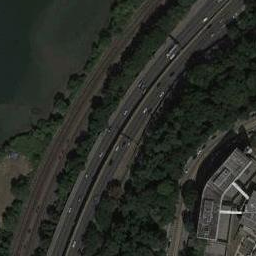

In [14]:
Image.fromarray((sample_source_img*255).astype(np.uint8))

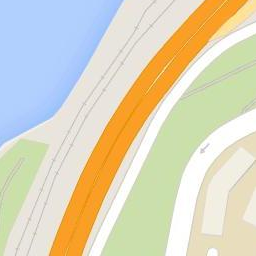

In [15]:

Image.fromarray((sample_target_img*255).astype(np.uint8))

In [16]:
dm = QartezatorDataModule(
    root_path=root_path,
    train_txt_path=train_txt_path,
    val_txt_path=val_txt_path,
    test_txt_path=test_txt_path,
    input_size=256
)
train_dataloader = dm.train_dataloader()
val_dataloader = dm.val_dataloader()
test_dataloader = dm.test_dataloader()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [17]:
for batch in train_dataloader:
    source, target = batch
    print(f'Source batch shape: {source.shape}')
    print(f'Target batch shape: {target.shape}\n')
    break

<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(worker_seed)
<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(worker_seed)
<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(worker_seed)
<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float

Source batch shape: torch.Size([32, 3, 256, 256])
Target batch shape: torch.Size([32, 3, 256, 256])



In [18]:
len(train_dataloader.dataset)

2792

In [19]:
len(val_dataloader.dataset)

250

In [20]:
len(test_dataloader.dataset)

250

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import init
import functools
from torch.optim import lr_scheduler

In [22]:

# # Define the U-Net model

# class UnetGenerator(nn.Module):
#     """Create a Unet-based generator"""

#     def __init__(self, input_nc, output_nc, num_downs, ngf=64, norm_layer=nn.BatchNorm2d, use_dropout=False):
#         """Construct a Unet generator
#         Parameters:
#             input_nc (int)  -- the number of channels in input images
#             output_nc (int) -- the number of channels in output images
#             num_downs (int) -- the number of downsamplings in UNet. For example, # if |num_downs| == 7,
#                                 image of size 128x128 will become of size 1x1 # at the bottleneck
#             ngf (int)       -- the number of filters in the last conv layer
#             norm_layer      -- normalization layer

#         We construct the U-Net from the innermost layer to the outermost layer.
#         It is a recursive process.
#         """
#         super(UnetGenerator, self).__init__()
#         # construct unet structure
#         # unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=None, norm_layer=norm_layer, innermost=True)  # add the innermost layer
#         for i in range(num_downs - 5):          # add intermediate layers with ngf * 8 filters
#             unet_block = UnetSkipConnectionBlock(ngf * 8, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer, use_dropout=use_dropout)
#         # gradually reduce the number of filters from ngf * 8 to ngf
#         unet_block = UnetSkipConnectionBlock(ngf * 4, ngf * 8, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
#         unet_block = UnetSkipConnectionBlock(ngf * 2, ngf * 4, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
#         unet_block = UnetSkipConnectionBlock(ngf, ngf * 2, input_nc=None, submodule=unet_block, norm_layer=norm_layer)
#         self.model = UnetSkipConnectionBlock(output_nc, ngf, input_nc=input_nc, submodule=unet_block, outermost=True, norm_layer=norm_layer)  # add the outermost layer

#     def forward(self, input):
#         """Standard forward"""
#         return self.model(input)


# def get_norm_layer(norm_type='instance'):
#     """Return a normalization layer

#     Parameters:
#         norm_type (str) -- the name of the normalization layer: batch | instance | none

#     For BatchNorm, we use learnable affine parameters and track running statistics (mean/stddev).
#     For InstanceNorm, we do not use learnable affine parameters. We do not track running statistics.
#     """
#     if norm_type == 'batch':
#         norm_layer = functools.partial(nn.BatchNorm2d, affine=True, track_running_stats=True)
#     elif norm_type == 'instance':
#         norm_layer = functools.partial(nn.InstanceNorm2d, affine=False, track_running_stats=False)
#     elif norm_type == 'none':
#         def norm_layer(x):
#             return Identity()
#     else:
#         raise NotImplementedError('normalization layer [%s] is not found' % norm_type)
#     return norm_layer

# class UnetSkipConnectionBlock(nn.Module):
#     """Defines the Unet submodule with skip connection.
#         X -------------------identity----------------------
#         |-- downsampling -- |submodule| -- upsampling --|
#     """

#     def __init__(self, outer_nc, inner_nc, input_nc=None,
#                  submodule=None, outermost=False, innermost=False, norm_layer=nn.BatchNorm2d, use_dropout=False):
#         """Construct a Unet submodule with skip connections.

#         Parameters:
#             outer_nc (int) -- the number of filters in the outer conv layer
#             inner_nc (int) -- the number of filters in the inner conv layer
#             input_nc (int) -- the number of channels in input images/features
#             submodule (UnetSkipConnectionBlock) -- previously defined submodules
#             outermost (bool)    -- if this module is the outermost module
#             innermost (bool)    -- if this module is the innermost module
#             norm_layer          -- normalization layer
#             use_dropout (bool)  -- if use dropout layers.
#         """
#         super(UnetSkipConnectionBlock, self).__init__()
#         self.outermost = outermost
#         if type(norm_layer) == functools.partial:
#             use_bias = norm_layer.func == nn.InstanceNorm2d
#         else:
#             use_bias = norm_layer == nn.InstanceNorm2d
#         if input_nc is None:
#             input_nc = outer_nc
#         downconv = nn.Conv2d(input_nc, inner_nc, kernel_size=4,
#                              stride=2, padding=1, bias=use_bias)
#         downrelu = nn.LeakyReLU(0.2, True)
#         downnorm = norm_layer(inner_nc)
#         uprelu = nn.ReLU(True)
#         upnorm = norm_layer(outer_nc)

#         if outermost:
#             upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
#                                         kernel_size=4, stride=2,
#                                         padding=1)
#             down = [downconv]
#             up = [uprelu, upconv, nn.Tanh()]
#             model = down + [submodule] + up
#         elif innermost:
#             upconv = nn.ConvTranspose2d(inner_nc, outer_nc,
#                                         kernel_size=4, stride=2,
#                                         padding=1, bias=use_bias)
#             down = [downrelu, downconv]
#             up = [uprelu, upconv, upnorm]
#             model = down + up
#         else:
#             upconv = nn.ConvTranspose2d(inner_nc * 2, outer_nc,
#                                         kernel_size=4, stride=2,
#                                         padding=1, bias=use_bias)
#             down = [downrelu, downconv, downnorm]
#             up = [uprelu, upconv, upnorm]

#             if use_dropout:
#                 model = down + [submodule] + up + [nn.Dropout(0.5)]
#             else:
#                 model = down + [submodule] + up

#         self.model = nn.Sequential(*model)

#     def forward(self, x):
#         if self.outermost:
#             return self.model(x)
#         else:   # add skip connections
#             return torch.cat([x, self.model(x)], 1)

# model = UnetGenerator(3, 3, 7, ngf=64, norm_layer='batch', use_dropout=False)


In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels , in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_channels, out_channels, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.out_channels = out_channels
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        factor = 2 if bilinear else 1
        self.down4 = Down(512, 1024 // factor)
        self.up1 = Up(1024, 512 // factor, bilinear)
        self.up2 = Up(512, 256 // factor, bilinear)
        self.up3 = Up(256, 128 // factor, bilinear)
        self.up4 = Up(128, 64, bilinear)
        self.outc = OutConv(64, out_channels)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

In [29]:
unet_model = UNet(3,3)
unet_model.load_state_dict(torch.load('best_qartezator_unet_0.05666.pth'))
# Define loss function and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.Adam(unet_model.parameters(), lr=0.00001)


def train_step(
    model: torch.nn.Module,
    data_loader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device = 'cuda'
):
    model.train()
    train_loss = 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} ")

    
def val_step(
    data_loader: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    loss_fn: torch.nn.Module,
    device = 'cuda'
):
    test_loss = 0
    model.to(device)
    model.eval()
    with torch.no_grad(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
        test_loss /= len(data_loader)
        print(f"Validation loss: {test_loss:.5f}\n")
    return test_loss

def train_model(model, model_name, loss_fn, optimizer, train_loader, val_loader, epochs=500, seed=0, scheduler=None, device='cuda'):
    best_val_loss = np.inf
    best_path = ''
    
    torch.manual_seed(seed)

    for epoch in range(epochs):
        print(f"Epoch: {epoch}\n---------")

        train_step(data_loader=train_loader, 
            model=model, 
            loss_fn=loss_fn,
            optimizer=optimizer,
            device=device
        )
        
        if scheduler is not None:
            scheduler.step()
 
        val_loss = val_step(data_loader=val_loader,
            model=model,
            loss_fn=loss_fn,
            device=device
        )

        if epoch % 5 == 0:
            for source, target in val_dataloader:
                source = source.to(device)
                model.to(device)
                test_pred = model(source)
                test_pred = test_pred.detach().permute(0,2,3,1).clip(0, 1).cpu().numpy()
                grid = []
                for i in range(len(test_pred)):
                    s = source[i].permute(1,2,0).detach().cpu().numpy()
                    s = (s * 255).astype(np.uint8)
                    t = target[i].permute(1,2,0).detach().cpu().numpy()
                    t = (t * 255).astype(np.uint8)
                    tp = test_pred[i]
                    tp = (tp * 255).astype(np.uint8)
                    grid.append(np.hstack([s, t, tp]))
                grid = np.vstack(grid)
                Image.fromarray(grid).save(f'grid_{epoch}.png')
                break

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_path = f'best_{model_name}_{val_loss:.5f}.pth'
            print(f"Saving best {model_name} with val_loss={val_loss}")
            torch.save(obj=model.state_dict(), f=best_path)

                
        torch.save(obj=model.state_dict(), f=f'last_{model_name}.pth')
    
    return model.load_state_dict(torch.load(f=best_path))

    
train_model(unet_model, 'qartezator_unet', loss_fn, optimizer, train_dataloader, val_dataloader, epochs=500)

Epoch: 0
---------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(worker_seed)
<ipython-input-2-c5e418e3ad89>:24: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(worker_see

OutOfMemoryError: ignored